Using device: cpu


100%|██████████| 9.91M/9.91M [00:00<00:00, 17.6MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 484kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 3.86MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 4.84MB/s]


Epoch 1 [100/938] Loss: 0.8273
Epoch 1 [200/938] Loss: 0.2439
Epoch 1 [300/938] Loss: 0.1585
Epoch 1 [400/938] Loss: 0.1187
Epoch 1 [500/938] Loss: 0.1128
Epoch 1 [600/938] Loss: 0.0851
Epoch 1 [700/938] Loss: 0.0899
Epoch 1 [800/938] Loss: 0.0758
Epoch 1 [900/938] Loss: 0.0623
Test Accuracy: 97.51%
Reached target accuracy >95%. Stopping training.


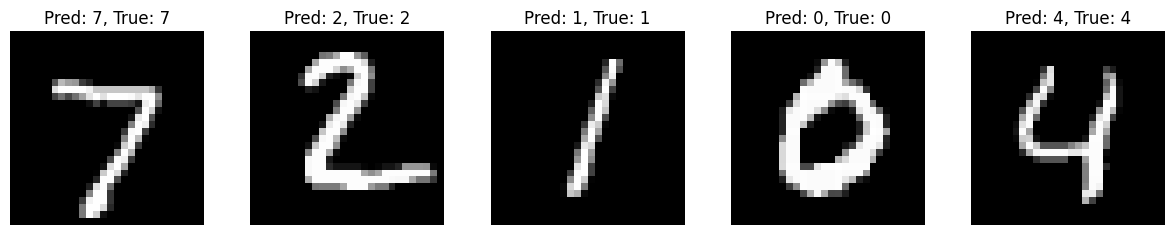

In [ ]:
# 1. Import libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

# 2. Setup device (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# 3. Load MNIST dataset
transform = transforms.Compose([
    transforms.ToTensor(),  # convert to tensor and normalize to [0,1]
])

train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# 4. Define CNN model
class CNNModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, 3)   # input channels, output channels, kernel size
        self.conv2 = nn.Conv2d(32, 64, 3)
        self.fc1 = nn.Linear(64 * 5 * 5, 128)  # flatten size calculation
        self.fc2 = nn.Linear(128, 10)  # 10 output classes for digits 0-9

    def forward(self, x):
        x = F.relu(self.conv1(x))        # (batch, 32, 26, 26)
        x = F.max_pool2d(x, 2)           # (batch, 32, 13, 13)
        x = F.relu(self.conv2(x))        # (batch, 64, 11, 11)
        x = F.max_pool2d(x, 2)           # (batch, 64, 5, 5)
        x = x.view(-1, 64 * 5 * 5)       # flatten
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

model = CNNModel().to(device)

# 5. Setup loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 6. Training loop
def train(model, device, train_loader, optimizer, criterion, epoch):
    model.train()
    running_loss = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if batch_idx % 100 == 99:
            print(f"Epoch {epoch} [{batch_idx+1}/{len(train_loader)}] Loss: {running_loss/100:.4f}")
            running_loss = 0

# 7. Test function to evaluate accuracy
def test(model, device, test_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            _, predicted = torch.max(output.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()
    accuracy = 100 * correct / total
    print(f"Test Accuracy: {accuracy:.2f}%")
    return accuracy

# 8. Train for 5 epochs and evaluate
for epoch in range(1, 6):
    train(model, device, train_loader, optimizer, criterion, epoch)
    acc = test(model, device, test_loader)
    if acc > 95:
        print("Reached target accuracy >95%. Stopping training.")
        break

# 9. Visualize 5 sample predictions
model.eval()
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)
example_data, example_targets = example_data.to(device), example_targets.to(device)
output = model(example_data)
preds = output.argmax(dim=1, keepdim=True)

plt.figure(figsize=(12, 6))
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.tight_layout()
    plt.imshow(example_data[i].cpu().squeeze(), cmap='gray', interpolation='none')
    plt.title(f"Pred: {preds[i].item()}, True: {example_targets[i].item()}")
    plt.axis('off')
plt.show()


In [2]:
# Step 1: Import Libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.preprocessing import LabelEncoder

# Step 2: Load the Dataset
df = pd.read_csv("Iris.csv")  # Ensure 'iris.csv' is in your working directory
print("First 5 rows of the dataset:")
print(df.head())

# Step 3: Check and Handle Missing Values
print("\nMissing values in each column:")
print(df.isnull().sum())

# If there are missing values, we drop those rows
df = df.dropna()

# Step 4: Encode Labels (Species to Numbers)
le = LabelEncoder()
df['Species'] = le.fit_transform(df['Species'])
print("\nUnique values in species after encoding:")
print(df['Species'].unique())

# Step 5: Split into Features and Target
X = df.drop('Species', axis=1)
y = df['Species']

# Step 6: Train-Test Split (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 7: Train Decision Tree Classifier
model = DecisionTreeClassifier(random_state=42)
model.fit(X_train, y_train)

# Step 8: Make Predictions
y_pred = model.predict(X_test)

# Step 9: Evaluate the Model
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')

print("\nModel Evaluation:")
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")


First 5 rows of the dataset:
   Id  SepalLengthCm  SepalWidthCm  PetalLengthCm  PetalWidthCm      Species
0   1            5.1           3.5            1.4           0.2  Iris-setosa
1   2            4.9           3.0            1.4           0.2  Iris-setosa
2   3            4.7           3.2            1.3           0.2  Iris-setosa
3   4            4.6           3.1            1.5           0.2  Iris-setosa
4   5            5.0           3.6            1.4           0.2  Iris-setosa

Missing values in each column:
Id               0
SepalLengthCm    0
SepalWidthCm     0
PetalLengthCm    0
PetalWidthCm     0
Species          0
dtype: int64

Unique values in species after encoding:
[0 1 2]

Model Evaluation:
Accuracy: 1.00
Precision: 1.00
Recall: 1.00


In [4]:
# Step 1: Install spaCy and download English model
!pip install spacy
!python -m spacy download en_core_web_sm

# Step 2: Sample Amazon Product Reviews
reviews = [
    "I love my new Apple iPhone 13, the camera is fantastic!",
    "The Samsung Galaxy Buds are terrible. Waste of money.",
    "Dell XPS 15 is the best laptop I’ve used for programming.",
    "Avoid this Sony TV, it stopped working in a week.",
    "The Logitech mouse is super smooth and responsive.",
    "This Lenovo ThinkPad is amazing for work and travel!",
    "Do not buy the Huawei P30 — the battery life is awful!"
]

# Step 3: Load spaCy model
import spacy
nlp = spacy.load("en_core_web_sm")

# 💬 Step 4: Define simple rule-based sentiment analyzer
positive_words = ["love", "fantastic", "best", "super", "smooth", "great", "amazing", "responsive"]
negative_words = ["terrible", "waste", "avoid", "bad", "stopped", "worst", "hate", "awful"]

def analyze_sentiment(text):
    text = text.lower()
    pos_score = sum(word in text for word in positive_words)
    neg_score = sum(word in text for word in negative_words)

    if pos_score > neg_score:
        return "Positive"
    elif neg_score > pos_score:
        return "Negative"
    else:
        return "Neutral"

# Step 5: Run NER + Sentiment on each review
for review in reviews:
    doc = nlp(review)

    # Extract named entities
    entities = [(ent.text, ent.label_) for ent in doc.ents if ent.label_ in ['ORG', 'PRODUCT']]

    # Sentiment
    sentiment = analyze_sentiment(review)

    # Display Results
    print("="*60)
    print(f"Review: {review}")
    print(f"Entities (Product/Brand): {entities}")
    print(f"Sentiment: {sentiment}")


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 98.1 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.
Review: I love my new Apple iPhone 13, the camera is fantastic!
Entities (Product/Brand): [('Apple', 'ORG')]
Sentiment: Positive
Review: The Samsung Galaxy Buds are terrible. Waste of money.
Entities (Product/Brand): []
Sentiment: Negative
Review: Dell XPS 15 is the best laptop I’ve used for programming.
Entities (Product/Brand): []
Sentiment: Positive
Review: Avoid this Sony TV, it stopped working in a week.
Entities (Product/Brand): [('Sony', 'ORG')]
Sentiment: Negative
Review: The Logitech mouse is super smooth and responsive.
Entities (Product/Brand): [('Logitech', 'ORG')]